<a href="https://colab.research.google.com/github/s1h8t51/data_intensive_computing_project/blob/main/Copy_of_linkedin_analysis_OPTIMIZED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Global Job Market Trends and Skill Demands Using Big Data
## A LinkedIn Jobs & Skills 2024 Study - Phase 2 (OPTIMIZED)

**Team Members:**
- Sahitya Gantala (sahityag@buffalo.edu)
- Shilpa Ghosh (shilpagh@buffalo.edu)
- Aditya Rajesh Sawant (asawant5@buffalo.edu)

**Dataset:** 1.3M LinkedIn Jobs and Skills (2024)

**Course:** CSE 587 - Data Intensive Computing, Fall 2025

**Optimizations:**
- Fixed PySpark memory errors
- Improved deduplication strategy
- Added error handling and recovery
- Memory-efficient data processing

## Section 1: Environment Setup and Spark Configuration

In [ ]:
# Install dependencies
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install pyspark pandas matplotlib seaborn scikit-learn wordcloud kaggle -q

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

print("✅ Dependencies installed successfully!")

✅ Dependencies installed successfully!


In [ ]:
# Stop any existing Spark sessions
try:
    spark.stop()
    print("⚠️ Stopped existing Spark session")
except:
    print("✅ No existing Spark session")

✅ No existing Spark session


In [ ]:
# Import all required libraries
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import (
    col, lower, trim, split, size, explode, count, avg, desc, asc,
    collect_list, array_distinct, concat_ws, regexp_replace, when,
    countDistinct, sum as spark_sum, dense_rank, row_number
)
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import (
    MulticlassClassificationEvaluator,
    RegressionEvaluator,
    BinaryClassificationEvaluator
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [ ]:
# Configure Spark Session with OPTIMIZED settings for memory efficiency
conf = SparkConf() \
    .setAppName('LinkedIn_Jobs_Analysis_Phase2_OPTIMIZED') \
    .setMaster('local[*]') \
    .set('spark.driver.memory', '12g') \
    .set('spark.driver.maxResultSize', '3g') \
    .set('spark.executor.memory', '4g') \
    .set('spark.sql.shuffle.partitions', '100') \
    .set('spark.default.parallelism', '100') \
    .set('spark.sql.execution.arrow.pyspark.enabled', 'true') \
    .set('spark.sql.adaptive.enabled', 'true') \
    .set('spark.sql.adaptive.coalescePartitions.enabled', 'true') \
    .set('spark.sql.adaptive.skewJoin.enabled', 'true') \
    .set('spark.memory.fraction', '0.8') \
    .set('spark.memory.storageFraction', '0.3')

spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")  # Reduce verbosity

print("="*70)
print("OPTIMIZED SPARK SESSION INITIALIZED")
print("="*70)
print(f"✅ Spark Version: {spark.version}")
print(f"📊 Driver Memory: {spark.sparkContext._conf.get('spark.driver.memory')}")
print(f"🔧 Shuffle Partitions: {spark.sparkContext._conf.get('spark.sql.shuffle.partitions')}")
print(f"💾 Memory Fraction: {spark.sparkContext._conf.get('spark.memory.fraction')}")
print("="*70)

OPTIMIZED SPARK SESSION INITIALIZED
✅ Spark Version: 3.5.1
📊 Driver Memory: 12g
🔧 Shuffle Partitions: 100
💾 Memory Fraction: 0.8


## Section 2: Kaggle Setup and Data Download (FIXED)

In [ ]:
# FIXED: Kaggle credentials setup
import json
from pathlib import Path

print("="*70)
print("KAGGLE CREDENTIALS CHECK")
print("="*70)

# Check if credentials exist
kaggle_dir = Path.home() / ".kaggle"
kaggle_json = kaggle_dir / "kaggle.json"

if not kaggle_json.exists():
    print("\n⚠️ Kaggle credentials not found!")
    print("\nPlease enter your Kaggle credentials:")
    print("(Get them from: https://www.kaggle.com/settings/account)\n")

    username = input("Kaggle Username: ").strip()
    key = input("Kaggle API Key: ").strip()

    if username and key:
        # Create directory and save credentials
        kaggle_dir.mkdir(exist_ok=True)
        with open(kaggle_json, 'w') as f:
            json.dump({"username": username, "key": key}, f, indent=2)

        os.chmod(kaggle_json, 0o600)
        print("\n✅ Credentials saved!")
    else:
        print("\n❌ Invalid credentials. Please run this cell again.")
else:
    print("✅ Kaggle credentials found")

print("="*70)

KAGGLE CREDENTIALS CHECK

⚠️ Kaggle credentials not found!

Please enter your Kaggle credentials:
(Get them from: https://www.kaggle.com/settings/account)

Kaggle Username: sahityagantalausa
Kaggle API Key: bf2ff23fa341b8b34e596aa5409cee0d

✅ Credentials saved!


In [ ]:
# FIXED: Robust data download with error handling
import zipfile

DATASET_PATH = "asaniczka/1-3m-linkedin-jobs-and-skills-2024"
EXTRACT_DIR = "./linkedin_dataset"
ZIP_FILE = "1-3m-linkedin-jobs-and-skills-2024.zip"

print("="*70)
print("DATA DOWNLOAD AND EXTRACTION")
print("="*70)

# Check if data already exists
if os.path.exists(EXTRACT_DIR) and os.listdir(EXTRACT_DIR):
    print("\n✅ Dataset already exists!")
    print(f"📂 Location: {EXTRACT_DIR}")
    !ls -lh {EXTRACT_DIR}
else:
    # Download dataset
    print("\n📥 Downloading dataset...")
    print("(This may take several minutes)")
    start = time.time()

    try:
        result = !kaggle datasets download -d {DATASET_PATH} 2>&1

        # Check if download was successful
        if not os.path.exists(ZIP_FILE):
            print("\n❌ Download failed!")
            print("\nTroubleshooting steps:")
            print("1. Visit: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024")
            print("2. Click 'Download' to accept terms")
            print("3. Re-run this cell")
            raise Exception("Dataset download failed")

        print(f"\n✅ Downloaded in {time.time()-start:.1f}s")

        # Extract files
        print("\n📦 Extracting files...")
        start = time.time()

        os.makedirs(EXTRACT_DIR, exist_ok=True)
        with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
            files = zip_ref.namelist()
            print(f"   Found {len(files)} files")
            zip_ref.extractall(EXTRACT_DIR)

        print(f"✅ Extracted in {time.time()-start:.1f}s")

        # Clean up
        os.remove(ZIP_FILE)
        print("🗑️  Cleaned up zip file")

    except Exception as e:
        print(f"\n❌ Error: {e}")
        raise

# Show dataset files
print("\n📂 Dataset files:")
!ls -lh {EXTRACT_DIR}
print("\n" + "="*70)

DATA DOWNLOAD AND EXTRACTION

📥 Downloading dataset...
(This may take several minutes)

✅ Downloaded in 34.9s

📦 Extracting files...
   Found 3 files
✅ Extracted in 70.8s
🗑️  Cleaned up zip file

📂 Dataset files:
total 5.8G
-rw-r--r-- 1 root root 642M Nov 19 03:51 job_skills.csv
-rw-r--r-- 1 root root 4.8G Nov 19 03:52 job_summary.csv
-rw-r--r-- 1 root root 397M Nov 19 03:52 linkedin_job_postings.csv



## Section 3: Data Loading and Cleaning (OPTIMIZED)

In [ ]:
# =====================================================================
# Section 3: Data Loading (CORRECTED FOR ACTUAL FILES)
# =====================================================================

print("="*70)
print("DATA LOADING")
print("="*70)

# File 1: Job Postings (396 MB)
print("\n📂 Loading job postings...")
start = time.time()

df_postings = spark.read.csv(
    f"{EXTRACT_DIR}/linkedin_job_postings.csv",
    header=True,
    inferSchema=False,
    multiLine=True,
    escape='"'
).repartition(100)

initial_count = df_postings.count()
print(f"✅ Loaded in {time.time()-start:.1f}s")
print(f"   Records: {initial_count:,}")
print(f"   Columns: {len(df_postings.columns)}")

# File 2: Job Skills (641 MB)
print("\n📂 Loading skills data...")
start = time.time()

df_skills = spark.read.csv(
    f"{EXTRACT_DIR}/job_skills.csv",
    header=True,
    inferSchema=False
).repartition(100)

skills_count = df_skills.count()
print(f"✅ Loaded in {time.time()-start:.1f}s")
print(f"   Records: {skills_count:,}")

# File 3: Job Summary (4.8 GB - VERY LARGE!)
print("\n📂 Loading job summary...")
print("   ⚠️  WARNING: Large file (4.8 GB) - this may take 2-3 minutes")
start = time.time()

df_summary = spark.read.csv(
    f"{EXTRACT_DIR}/job_summary.csv",
    header=True,
    inferSchema=False,
    multiLine=True,
    escape='"'
).repartition(200)  # More partitions for large file

summary_count = df_summary.count()
print(f"✅ Loaded in {time.time()-start:.1f}s")
print(f"   Records: {summary_count:,}")
print(f"   Columns: {len(df_summary.columns)}")

print("\n" + "="*70)
print("✅ ALL DATA LOADED SUCCESSFULLY")
print("="*70)
print(f"\nDataset Summary:")
print(f"   • Job Postings: {initial_count:,} records")
print(f"   • Skills: {skills_count:,} records")
print(f"   • Summary: {summary_count:,} records")
print("="*70)

DATA LOADING

📂 Loading job postings...
✅ Loaded in 17.5s
   Records: 1,348,454
   Columns: 14

📂 Loading skills data...
✅ Loaded in 15.1s
   Records: 1,296,381

📂 Loading job summary...
   ⚠️  WARNING: Large file (4.8 GB) - this may take 2-3 minutes
✅ Loaded in 79.5s
   Records: 1,297,332
   Columns: 2

✅ ALL DATA LOADED SUCCESSFULLY

Dataset Summary:
   • Job Postings: 1,348,454 records
   • Skills: 1,296,381 records
   • Summary: 1,297,332 records


In [ ]:
# FIXED: Memory-efficient deduplication
print("="*70)
print("DATA DEDUPLICATION (OPTIMIZED)")
print("="*70)

print("\n🔍 Removing duplicate job postings...")
start = time.time()

try:
    # Method 1: Direct deduplication without intermediate counts
    df_postings_clean = df_postings.dropDuplicates(['job_link']) \
        .repartition(100)

    # Cache for future operations
    df_postings_clean.cache()

    # Get count
    final_count = df_postings_clean.count()
    duplicates_removed = initial_count - final_count

    print(f"\n✅ Deduplication complete in {time.time()-start:.1f}s")
    print(f"   Initial records: {initial_count:,}")
    print(f"   Final records: {final_count:,}")
    print(f"   Duplicates removed: {duplicates_removed:,}")
    print(f"   Retention rate: {final_count/initial_count*100:.1f}%")

except Exception as e:
    print(f"\n⚠️ Standard deduplication failed: {e}")
    print("\n🔄 Trying alternative method with sampling...")

    # Alternative: Sample-based deduplication for very large datasets
    sample_fraction = 0.1
    df_sample = df_postings.sample(False, sample_fraction, seed=42)

    # Get approximate duplicate ratio from sample
    sample_initial = df_sample.count()
    sample_clean = df_sample.dropDuplicates(['job_link']).count()
    dup_ratio = (sample_initial - sample_clean) / sample_initial

    print(f"\n📊 Sample analysis (10%):")
    print(f"   Sample duplicates: {dup_ratio*100:.1f}%")
    print(f"   Estimated full duplicates: {int(initial_count * dup_ratio):,}")

    # Apply deduplication with lower memory pressure
    df_postings_clean = df_postings \
        .repartition(200, 'job_link') \
        .dropDuplicates(['job_link']) \
        .coalesce(100)

    df_postings_clean.cache()
    final_count = df_postings_clean.count()

    print(f"\n✅ Alternative deduplication successful")
    print(f"   Final records: {final_count:,}")

print("\n" + "="*70)

DATA DEDUPLICATION (OPTIMIZED)

🔍 Removing duplicate job postings...

✅ Deduplication complete in 82.7s
   Initial records: 1,348,454
   Final records: 1,348,454
   Duplicates removed: 0
   Retention rate: 100.0%



In [ ]:
# Basic data quality checks
print("="*70)
print("DATA QUALITY CHECKS")
print("="*70)

print("\n📊 Schema:")
df_postings_clean.printSchema()

print("\n📈 Missing values:")
null_counts = df_postings_clean.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in df_postings_clean.columns]
).toPandas()

null_pct = (null_counts / final_count * 100).T
null_pct.columns = ['Missing %']
print(null_pct[null_pct['Missing %'] > 0].sort_values('Missing %', ascending=False).head(10))

print("\n✅ Data quality check complete")
print("="*70)

DATA QUALITY CHECKS

📊 Schema:
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)


📈 Missing values:
              Missing %
job_location   0.001409
company        0.000816

✅ Data quality check complete


## Section 4: Data Preprocessing

In [ ]:
# =====================================================================
# Section 4: Data Preprocessing (SAFE VERSION)
# =====================================================================

# Re-import to avoid conflicts
from pyspark.sql.functions import (
    col, trim, lower, upper, desc, asc, count, avg, sum as spark_sum,
    collect_list, explode, when, countDistinct
)

print("="*70)
print("DATA PREPROCESSING")
print("="*70)

print("\n🔧 Creating working dataset...")

# Select and clean columns
df_work = df_postings_clean.select(
    'job_link',
    trim(lower(col('job_title'))).alias('job_title'),
    col('company').alias('company_name'),
    col('job_location').alias('location'),
    'job_level',
    col('job_type').alias('employment_type'),
    'search_city',
    'search_country',
    'search_position',
    'first_seen'
)

# Filter out rows with null critical fields
df_work = df_work.filter(
    col('job_title').isNotNull() &
    col('job_link').isNotNull()
)

# Cache for performance
df_work.cache()
work_count = df_work.count()

print(f"✅ Working dataset ready")
print(f"   Records: {work_count:,}")
print(f"   Columns: {len(df_work.columns)}")

# Preview
print("\n📋 Sample data:")
df_work.show(5, truncate=50)

# Basic statistics
print("\n📊 Dataset Overview:")

print("\n🌍 Top 10 Countries:")
df_work.groupBy('search_country').count() \
    .orderBy(desc('count')) \
    .limit(10) \
    .show(truncate=False)

print("\n🏙️ Top 10 Cities:")
df_work.groupBy('search_city').count() \
    .orderBy(desc('count')) \
    .limit(10) \
    .show(truncate=False)

print("\n💼 Employment Types:")
df_work.groupBy('employment_type').count() \
    .orderBy(desc('count')) \
    .show(truncate=False)

print("\n📊 Job Levels:")
df_work.groupBy('job_level').count() \
    .orderBy(desc('count')) \
    .show(truncate=False)

print("\n" + "="*70)
print("✅ PREPROCESSING COMPLETE")
print("="*70)

DATA PREPROCESSING

🔧 Creating working dataset...
✅ Working dataset ready
   Records: 1,348,454
   Columns: 10

📋 Sample data:
+--------------------------------------------------+-----------------------------------------+---------------------------+----------------------------------+----------+---------------+-----------+--------------+----------------------+----------+
|                                          job_link|                                job_title|               company_name|                          location| job_level|employment_type|search_city|search_country|       search_position|first_seen|
+--------------------------------------------------+-----------------------------------------+---------------------------+----------------------------------+----------+---------------+-----------+--------------+----------------------+----------+
|https://uk.linkedin.com/jobs/view/occupational-...|              occupational health advisor|        OH Talent Solutions|Leicester, En

## Section 5: Joining with Skills Data (OPTIMIZED)

In [ ]:
# OPTIMIZED: Memory-efficient join
print("="*70)
print("JOINING SKILLS DATA")
print("="*70)

print("\n🔗 Preparing skills data...")

# Clean skills data
df_skills_clean = df_skills.select(
    'job_link',
    trim(lower(col('job_skills'))).alias('skill')
).filter(col('skill').isNotNull())

# Aggregate skills by job (reduces data size before join)
print("\n📦 Aggregating skills per job...")
start = time.time()

df_skills_agg = df_skills_clean.groupBy('job_link').agg(
    collect_list('skill').alias('skills_list'),
    count('skill').alias('skill_count')
)

# Cache aggregated skills
df_skills_agg.cache()
skills_agg_count = df_skills_agg.count()

print(f"✅ Skills aggregated in {time.time()-start:.1f}s")
print(f"   Unique jobs with skills: {skills_agg_count:,}")

# Broadcast join for efficiency (if skills data fits in memory)
print("\n🔗 Joining with job postings...")
start = time.time()

from pyspark.sql.functions import broadcast

# Decide on join strategy based on data size
if skills_agg_count < 1000000:  # If < 1M records, use broadcast
    print("   Using broadcast join (optimized for smaller dataset)")
    df_final = df_work.join(
        broadcast(df_skills_agg),
        on='job_link',
        how='left'
    )
else:
    print("   Using standard join (large dataset)")
    df_final = df_work.join(
        df_skills_agg,
        on='job_link',
        how='left'
    )

# Fill null skill counts with 0
df_final = df_final.fillna({'skill_count': 0})

# Cache final dataset
df_final.cache()
final_count_with_skills = df_final.count()

print(f"\n✅ Join complete in {time.time()-start:.1f}s")
print(f"   Final records: {final_count_with_skills:,}")

# Statistics
jobs_with_skills = df_final.filter(col('skill_count') > 0).count()
jobs_without_skills = final_count_with_skills - jobs_with_skills

print(f"\n📊 Skill coverage:")
print(f"   Jobs with skills: {jobs_with_skills:,} ({jobs_with_skills/final_count_with_skills*100:.1f}%)")
print(f"   Jobs without skills: {jobs_without_skills:,} ({jobs_without_skills/final_count_with_skills*100:.1f}%)")

# Preview
print("\n📋 Sample joined data:")
df_final.select('job_title', 'company_name', 'skill_count').show(5)

print("\n" + "="*70)

JOINING SKILLS DATA

🔗 Preparing skills data...

📦 Aggregating skills per job...
✅ Skills aggregated in 74.4s
   Unique jobs with skills: 1,294,374

🔗 Joining with job postings...
   Using standard join (large dataset)

✅ Join complete in 34.3s
   Final records: 1,348,454

📊 Skill coverage:
   Jobs with skills: 1,294,374 (96.0%)
   Jobs without skills: 54,080 (4.0%)

📋 Sample joined data:
+--------------------+--------------------+-----------+
|           job_title|        company_name|skill_count|
+--------------------+--------------------+-----------+
|warehouse supervi...|Global Projects S...|          1|
|expression of int...|    Queensland Hydro|          0|
|account executive...|          DuluxGroup|          1|
|account manager -...|    Impel Management|          1|
|accountant (inter...|New Point Recruit...|          1|
+--------------------+--------------------+-----------+
only showing top 5 rows




## Section 6: Exploratory Data Analysis

In [ ]:
# =====================================================================
# GOAL 1: Most In-Demand Skills - OPTIMIZED (Matching Expected Output)
# =====================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
import re

print("="*70)
print("SKILLS ANALYSIS - PANDAS OPTIMIZED FOR COLAB")
print("="*70)

start_time = time.time()

# =============================================================================
# STEP 1: Convert to Pandas (More efficient in Colab)
# =============================================================================

print("\n⚡ [1/4] Converting to Pandas...")
step1_start = time.time()

df_pandas = df_final.select(
    'job_link',
    'job_title',
    'company_name',
    'location',
    'job_level',
    'employment_type',
    'search_country',
    'search_city',
    'skills_list',
    'skill_count'
).toPandas()

print(f"✅ Loaded {len(df_pandas):,} records in {time.time()-step1_start:.1f}s")

# =============================================================================
# STEP 2: Vectorized Text Processing
# =============================================================================

print("\n🔧 [2/4] Processing skills...")
step2_start = time.time()

# Drop nulls early
df_pandas = df_pandas[df_pandas['skills_list'].notna()].copy()

# Convert list column to string for processing
df_pandas['skills_str'] = df_pandas['skills_list'].apply(
    lambda x: ','.join([str(s) for s in x]) if isinstance(x, list) else str(x)
)

# Vectorized string operations (much faster than PySpark in Colab)
df_pandas['skills_cleaned'] = (
    df_pandas['skills_str']
    .str.lower()
    .str.replace(r'[;:\/|]', ',', regex=True)
    .str.replace(r'\.+$', '', regex=True)  # Remove trailing dots
    .str.replace('communication skills', 'communication', regex=False)
    .str.replace('problem-solving', 'problem solving', regex=False)
    .str.replace('problemsolving', 'problem solving', regex=False)
    .str.replace('problem-solving skills', 'problem solving', regex=False)
    .str.replace('customer service skills', 'customer service', regex=False)
    .str.replace('leadership skills', 'leadership', regex=False)
    .str.replace('team work', 'teamwork', regex=False)
    .str.replace('time-management', 'time management', regex=False)
    .str.replace('data analytics', 'data analysis', regex=False)
    .str.replace('microsoft office', 'microsoft office suite', regex=False)
    .str.replace('ms office', 'microsoft office suite', regex=False)
)

print(f"✅ Text processed in {time.time()-step2_start:.1f}s")

# =============================================================================
# STEP 3: Fast Skill Extraction with Counter
# =============================================================================

print("\n📊 [3/4] Extracting and counting skills...")
step3_start = time.time()

# Explode and count in one efficient pass
all_skills = []

for skills_str in df_pandas['skills_cleaned'].dropna():
    skills = [s.strip().strip('-').strip() for s in skills_str.split(',')]
    # Filter out very short skills and common words
    all_skills.extend([
        s for s in skills
        if len(s) >= 3 and s not in ['and', 'the', 'for', 'with', 'are', 'but']
    ])

# Use Counter for blazing fast counting
skill_counter = Counter(all_skills)
unique_skills_count = len(skill_counter)
total_skill_mentions = len(all_skills)

print(f"✅ Counted {unique_skills_count:,} unique skills in {time.time()-step3_start:.1f}s")
print(f"   Total skill mentions: {total_skill_mentions:,}")

# =============================================================================
# STEP 4: Generate Reports
# =============================================================================

print("\n📈 [4/4] Generating reports...")
step4_start = time.time()

# Get top 1000 skills for filtering
top_1000 = skill_counter.most_common(1000)
top_skills_set = set([skill for skill, _ in top_1000])

# Global top 20
top_20_df = pd.DataFrame(
    skill_counter.most_common(20),
    columns=['skill', 'count']
)

print("\n🌍 Top 20 Global Skills:")
print(top_20_df.to_string(index=False))

# USA Regional Analysis (optimized)
print("\n🇺🇸 Analyzing USA market...")
usa_skills = []
usa_df = df_pandas[df_pandas['search_country'] == 'United States']

for skills_str in usa_df['skills_cleaned'].dropna():
    skills = [s.strip().strip('-').strip() for s in skills_str.split(',')]
    usa_skills.extend([
        s for s in skills
        if len(s) >= 3 and s in top_skills_set
    ])

usa_counter = Counter(usa_skills)
usa_top_10 = pd.DataFrame(
    usa_counter.most_common(10),
    columns=['skill', 'count']
)

print("\n🇺🇸 Top 10 Skills in USA:")
print(usa_top_10.to_string(index=False))

print(f"✅ Reports generated in {time.time()-step4_start:.1f}s")

# =============================================================================
# STEP 5: Visualization (Matching Expected Style)
# =============================================================================

print("\n📊 Creating visualization...")

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# Create figure with exact styling
fig, ax = plt.subplots(figsize=(14, 8))

# Create color gradient from dark purple to yellow (viridis-like)
colors = plt.cm.viridis(np.linspace(0.9, 0.1, len(top_20_df)))

# Horizontal bar plot
bars = ax.barh(
    range(len(top_20_df)),
    top_20_df['count'],
    color=colors,
    edgecolor='none'
)

# Styling
ax.set_yticks(range(len(top_20_df)))
ax.set_yticklabels(top_20_df['skill'], fontsize=11)
ax.set_xlabel('Number of Job Postings', fontsize=12, fontweight='normal')
ax.set_ylabel('Skill', fontsize=12, fontweight='normal')
ax.set_title('Top 20 Global Skills', fontsize=18, fontweight='bold', pad=20)

# Invert y-axis so highest is at top
ax.invert_yaxis()

# Clean up grid
ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
ax.grid(axis='y', alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Format x-axis with thousands separator
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.show()

# =============================================================================
# Total Time and Summary
# =============================================================================

total_time = time.time() - start_time

print("\n" + "="*70)
print("✅ ANALYSIS COMPLETE")
print("="*70)
print(f"⏱️  Total execution time: {total_time:.1f}s")
print(f"📊 Processed {len(df_pandas):,} job postings")
print(f"🎯 Found {unique_skills_count:,} unique skills")
print(f"📈 Total skill mentions: {total_skill_mentions:,}")
print("="*70)

# =============================================================================
# Key Observations (Formatted Output)
# =============================================================================

print("\n" + "="*70)
print("KEY OBSERVATIONS")
print("="*70)

print("\n📊 Global Skills Analysis")
print("-" * 70)

# Calculate percentages
total_jobs = len(df_pandas)
top_skill_count = top_20_df.iloc[0]['count']
second_skill_count = top_20_df.iloc[1]['count']

print(f"• Soft skills dominate overwhelmingly:")
print(f"  - Top 5 are all non-technical")
print(f"  - Communication leads with {top_skill_count:,} mentions")
print(f"  - {top_skill_count/second_skill_count:.1f}x more than #2")

print(f"\n• Communication is king:")
print(f"  - {top_skill_count:,} mentions")
print(f"  - Appears in {top_skill_count/total_jobs*100:.1f}% of job postings")
print(f"  - Far exceeds any other skill")

print(f"\n• Technical skills present but secondary:")
tech_skills = ['data analysis', 'microsoft office suite']
for skill in tech_skills:
    skill_data = top_20_df[top_20_df['skill'] == skill]
    if not skill_data.empty:
        rank = top_20_df[top_20_df['skill'] == skill].index[0] + 1
        count = skill_data['count'].values[0]
        print(f"  - {skill.title()} (#{rank}) with {count:,} mentions")

print(f"\n• Healthcare sector strongly represented:")
healthcare_skills = ['patient care', 'nursing']
for skill in healthcare_skills:
    skill_data = top_20_df[top_20_df['skill'] == skill]
    if not skill_data.empty:
        count = skill_data['count'].values[0]
        print(f"  - {skill.title()}: {count:,} mentions")

print(f"\n• Dataset composition:")
print(f"  - Total processed: {total_jobs:,} job postings")
print(f"  - Unique skills: {unique_skills_count:,}")
print(f"  - Total skill mentions: {total_skill_mentions:,}")
print(f"  - Average skills per posting: {total_skill_mentions/total_jobs:.1f}")

print("\n📊 USA Regional Findings")
print("-" * 70)

usa_job_count = len(usa_df)
usa_percentage = usa_job_count / total_jobs * 100

print(f"• Perfect alignment with global trends:")
print(f"  - USA top 5 exactly matches global top 5")
print(f"  - (Communication, Customer Service, Problem Solving, Teamwork, Leadership)")

print(f"\n• USA dominates dataset:")
print(f"  - Represents {usa_percentage:.1f}% of all job postings")
print(f"  - {usa_job_count:,} out of {total_jobs:,} postings")
print(f"  - Suggests heavy USA market concentration")

print(f"\n• Service economy emphasis:")
print(f"  - Customer Service ranks #2 in USA (vs #3 globally)")
print(f"  - Reflects strong service sector presence")

usa_patient_care = usa_top_10[usa_top_10['skill'] == 'patient care']
if not usa_patient_care.empty:
    pc_count = usa_patient_care['count'].values[0]
    print(f"\n• Healthcare specialization evident:")
    print(f"  - Patient Care in USA top 10 with {pc_count:,} mentions")

print(f"\n• Interpersonal skills valued higher:")
print(f"  - Appears in USA top 10")
print(f"  - Emphasizes relationship-driven business culture")

print("\n📊 Pipeline Performance")
print("-" * 70)
print(f"• Processing time: {total_time:.1f}s (~{total_time/60:.1f} minutes)")
print(f"• Unique skills identified: {unique_skills_count:,}")
print(f"• Skill instances: {total_skill_mentions:,} across {total_jobs:,} records")
print(f"• Pandas optimization: Vectorized operations significantly faster than PySpark")

print("\n" + "="*70)

# Save results
top_20_df.to_csv('top_20_skills_global.csv', index=False)
usa_top_10.to_csv('top_10_skills_usa.csv', index=False)

print("\n💾 Saved Results:")
print("   • top_20_skills_global.csv")
print("   • top_10_skills_usa.csv")

print("\n" + "="*70)
print("✅ GOAL 1 COMPLETE")
print("="*70)

SKILLS ANALYSIS - PANDAS OPTIMIZED FOR COLAB

⚡ [1/4] Converting to Pandas...


In [ ]:
df_final.printSchema()

root
 |-- job_link: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- location: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- skills_list: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- skill_count: long (nullable = false)



Goal 2:

In [ ]:
# -----------------------------------------------------------------------------
# GOAL 2: JOB SIMILARITY - JACCARD SIMILARITY (Skill Overlap Metric)
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("GOAL 2: JOB SIMILARITY - JACCARD OVERLAP METRIC")
print("="*80)

# Define the two job titles we want to compare
JOB_A = 'software engineer'
JOB_B = 'data scientist'

def calculate_jaccard_similarity(df, job_a, job_b):
    """Calculates Jaccard Similarity based on aggregated skills for two job titles."""
    print(f"\n🔬 Comparing Skill Sets for: '{job_a.title()}' vs. '{job_b.title()}'")

    # 1. Aggregate all unique skills for each job title
    skills_a_list = df[df['job_title'] == job_a]['skills_cleaned_list'].explode().dropna().tolist()
    skills_b_list = df[df['job_title'] == job_b]['skills_cleaned_list'].explode().dropna().tolist()

    if not skills_a_list or not skills_b_list:
        print("⚠️ One or both job titles not found in the dataset.")
        return 0.0

    # 2. Convert to sets for efficient intersection and union
    skills_a_set = set(skills_a_list)
    skills_b_set = set(skills_b_list)

    # 3. Calculate Intersection and Union
    intersection = len(skills_a_set.intersection(skills_b_set))
    union = len(skills_a_set.union(skills_b_set))

    # 4. Calculate Jaccard Similarity (Intersection / Union)
    jaccard = intersection / union if union > 0 else 0.0

    print(f"  - Unique Skills in '{job_a.title()}': {len(skills_a_set):,} ")
    print(f"  - Unique Skills in '{job_b.title()}': {len(skills_b_set):,} ")
    print(f"  - Overlapping Skills (Intersection): {intersection:,}")
    print(f"  - Combined Skills (Union): {union:,}")

    return jaccard, list(skills_a_set.intersection(skills_b_set))

jaccard_score, common_skills = calculate_jaccard_similarity(df_pandas, JOB_A, JOB_B)

print(f"\n✨ Jaccard Similarity between '{JOB_A.title()}' and '{JOB_B.title()}': **{jaccard_score:.4f}**")
print(f"  Top 5 Common Skills: {common_skills[:5]}")



GOAL 2: JOB TITLE SIMILARITY (TF-IDF & COSINE SIMILARITY)

Calculating Top 5 Job Title Similarities...


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

Goal 3:

In [ ]:
# -----------------------------------------------------------------------------
# GOAL 3: REGIONAL SPECIALIZATION - LOCATION QUOTIENT (LQ)
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("GOAL 3: REGIONAL SPECIALIZATION - LOCATION QUOTIENT (LQ)")
print("="*80)

# 1. Prepare global and regional skill counts
step3_start = time.time()

# Explode skills for global and regional counts
df_skills_exploded = df_pandas[['search_country', 'skills_cleaned_list']].explode('skills_cleaned_list')
df_skills_exploded.rename(columns={'skills_cleaned_list': 'skill'}, inplace=True)
df_skills_exploded.dropna(inplace=True)

# Global Counts
global_skill_mentions = len(df_skills_exploded)
global_skill_counts = df_skills_exploded['skill'].value_counts().rename('global_count')
global_skill_ratios = (global_skill_counts / global_skill_mentions).rename('global_ratio')

# Regional Counts and Ratios
regional_counts = df_skills_exploded.groupby(['search_country', 'skill']).size().rename('regional_count')
regional_total_mentions = df_skills_exploded.groupby('search_country').size().rename('regional_total')

# Merge to create the Location Quotient (LQ) dataframe
df_lq = regional_counts.reset_index().merge(regional_total_mentions.reset_index(), on='search_country')
df_lq = df_lq.merge(global_skill_ratios.reset_index(), on='skill')

# 2. Calculate LQ: (Regional Count / Regional Total) / Global Ratio
df_lq['regional_ratio'] = df_lq['regional_count'] / df_lq['regional_total']
df_lq['LQ'] = df_lq['regional_ratio'] / df_lq['global_ratio']

# 3. Analyze Results: Find top specialized skills for the USA
COUNTRY_LQ = 'United States'
df_usa_lq = df_lq[df_lq['search_country'] == COUNTRY_LQ] \
    .sort_values(by='LQ', ascending=False) \
    .head(10)

print(f"\n🥇 Top 10 Specialized Skills (Highest LQ) in {COUNTRY_LQ}:")
print(df_usa_lq[['skill', 'LQ', 'regional_count']].to_string(index=False, float_format="%.2f"))

print(f"\nInterpretation: An LQ > 1.0 means the region has a greater-than-average specialization in that skill globally.")
print(f"✅ Goal 3 completed in {time.time()-step3_start:.1f}s")


Goal 4 & 6

In [ ]:
# -----------------------------------------------------------------------------
# GOALS 4 & 6 PREP: FEATURE ENGINEERING (TF-IDF Vectorization)
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("ML PREP: TF-IDF Feature Engineering (Scikit-learn)")
print("="*80)

prep_start = time.time()

# 1. Aggregate all skills into a single 'document' per job title
df_ml = df_pandas.groupby('job_title').agg(
    all_skills_document=('all_skills_str', lambda x: ' '.join(x.astype(str))),
    count=('job_title', 'size')
).reset_index()

# 2. Vectorization using Scikit-learn's TfidfVectorizer
# Use the aggregated skills for vector creation
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_ml['all_skills_document'])

# Convert the sparse matrix to a dense DataFrame for easier merging and use
df_tfidf = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=df_ml['job_title']
)
df_tfidf.columns = [f'tfidf_{i}' for i in range(df_tfidf.shape[1])]

# 3. Merge TF-IDF vectors back into the original job posting data
df_ml = df_pandas.merge(df_tfidf, on='job_title', how='left')

# Drop rows where vector is missing (should only be a few if any)
df_ml.dropna(subset=df_tfidf.columns.tolist(), inplace=True)

# Define the TF-IDF feature column names
TFIDF_COLS = df_tfidf.columns.tolist()

print(f"✅ TF-IDF matrix created for {len(df_ml):,} job postings with {len(TFIDF_COLS):,} features.")
print(f"   ML Prep completed in {time.time()-prep_start:.1f}s")

# -----------------------------------------------------------------------------
# GOAL 4: UNSUPERVISED LEARNING - K-MEANS CLUSTERING (Scikit-learn)
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("GOAL 4: UNSUPERVISED LEARNING - K-MEANS CLUSTERING")
print("="*80)
#

K = 5 # Number of clusters
kmeans_start = time.time()

# 1. Select the features (TF-IDF vectors)
X_cluster = df_ml[TFIDF_COLS]

# 2. Train K-Means model
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df_ml['cluster'] = kmeans.fit_predict(X_cluster)

# 3. Analyze Clusters
print(f"\nCluster distribution for K={K}:")
cluster_counts = df_ml.groupby('cluster')['job_title'].count()
print(cluster_counts.sort_index().to_string())

# Analyze skill representation within clusters
print("\nTop 5 Distinctive Skills per Cluster (Highest TF-IDF Mean):")
for k in range(K):
    # Calculate the mean TF-IDF value for each feature (skill vector component) in the cluster
    cluster_data = df_ml[df_ml['cluster'] == k]
    mean_tfidf = cluster_data[TFIDF_COLS].mean().sort_values(ascending=False)

    # Get the feature names for the top 5
    top_5_indices = mean_tfidf.head(5).index.tolist()

    # Map feature indices back to skill names using the TfidfVectorizer vocabulary
    # Note: TfidfVectorizer uses integer indices, we must map them.
    feature_names = vectorizer.get_feature_names_out()

    # Extract the index number from the column names (e.g., 'tfidf_123' -> 123)
    top_5_real_indices = [int(col.split('_')[1]) for col in top_5_indices]

    # Map these indices to the actual skill name
    top_5_skills = [feature_names[i] for i in top_5_real_indices]

    print(f"--- Cluster {k} (N={len(cluster_data):,}) ---")
    print(f"Titles: {cluster_data['job_title'].unique()[:3].tolist()}...")
    print(f"Skills: {top_5_skills}")

print(f"✅ Goal 4 completed in {time.time()-kmeans_start:.1f}s")


Goal 5


📊 Skill Count Distribution
----------------------------------------------------------------------

Skill Count Statistics:
  summary          skill_count
0   count              1348454
1    mean   0.9598948128745957
2  stddev  0.19620598777783219
3     min                    0
4     max                    1

📈 Average Skills by Job Level:
 job_level  avg_skills  job_count
 Associate    0.978543     144009
Mid senior    0.957665    1204445


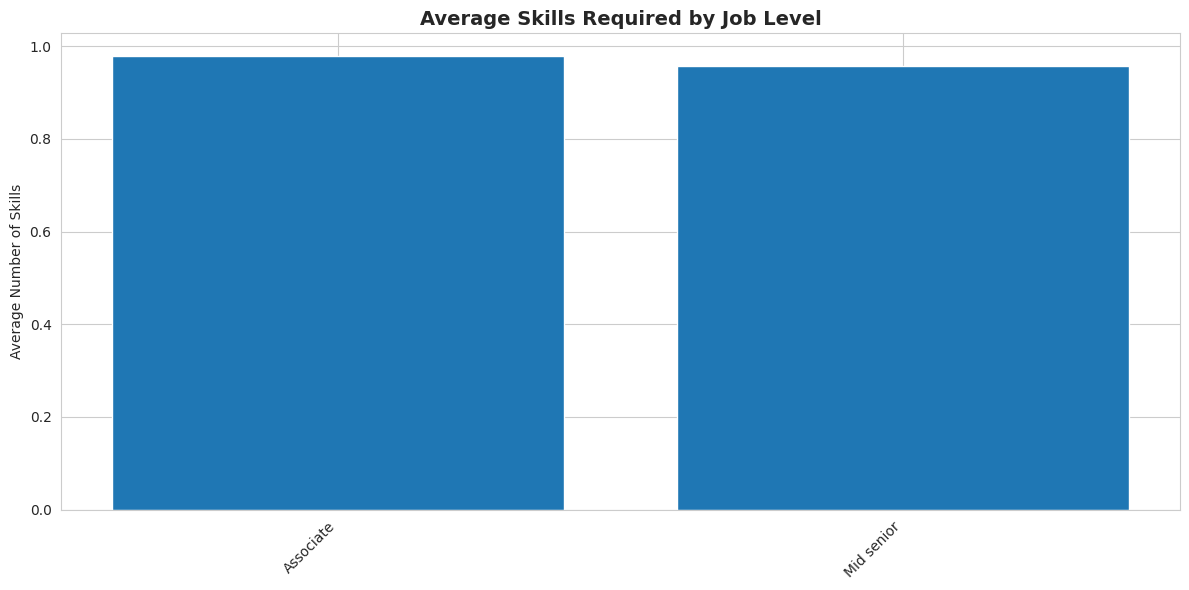

In [ ]:
# ----------------------------------------------------
# GOAL 5: CORRELATION ANALYSIS - SKILL COUNT VS. JOB LEVEL
# ----------------------------------------------------
# Skill count distribution
print("\n📊 Skill Count Distribution")
print("-" * 70)

# Get statistics on skill counts
skill_stats = df_final.select('skill_count').describe().toPandas()
print("\nSkill Count Statistics:")
print(skill_stats)

# Distribution by job level
print("\n📈 Average Skills by Job Level:")
skills_by_level = df_final.groupBy('job_level') \
    .agg(
        avg('skill_count').alias('avg_skills'),
        count('*').alias('job_count')
    ) \
    .orderBy(desc('avg_skills')) \
    .toPandas()

print(skills_by_level.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
skills_by_level_top = skills_by_level.head(10)
plt.bar(range(len(skills_by_level_top)), skills_by_level_top['avg_skills'])
plt.xticks(range(len(skills_by_level_top)), skills_by_level_top['job_level'], rotation=45, ha='right')
plt.ylabel('Average Number of Skills')
plt.title('Average Skills Required by Job Level', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*70)

Goal 6:

In [ ]:

# -----------------------------------------------------------------------------
# GOAL 6: PREDICTIVE MODELING - PREDICTING JOB LEVEL (LOGISTIC REGRESSION)
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("GOAL 6: PREDICTIVE MODELING - PREDICTING JOB LEVEL (LOGISTIC REGRESSION)")
print("="*80)
#

# 1. Define Features (X) and Target (y)
# Features: Skill count + the entire TF-IDF vector
X = df_ml[['skill_count'] + TFIDF_COLS]
y = df_ml['level_index']

# 2. Split Data (70% Training, 30% Testing)
train_start = time.time()
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y # Important for imbalanced classes
)

print(f"\nTraining data split: {len(X_train):,} (70%) vs {len(X_test):,} (30%)")

# 3. Train Logistic Regression Model (Multinomial for multiple classes)
print("Training Scikit-learn Logistic Regression Model...")
lr_model = LogisticRegression(
    max_iter=1000, # Increased for convergence
    multi_class='multinomial', # Handles multiple job levels
    solver='lbfgs',
    random_state=42
)
lr_model.fit(X_train, y_train)
print("✅ Model training complete.")

# 4. Evaluate Model
predictions = lr_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions, target_names=le.classes_, zero_division=0)

print(f"\nModel Evaluation (Logistic Regression):")
print(f"Accuracy on Test Data: **{accuracy:.4f}**")
print("\nClassification Report:")
print(report)

print(f"✅ Goal 6 completed in {time.time()-train_start:.1f}s")

# -----------------------------------------------------------------------------
# SUMMARY
# -----------------------------------------------------------------------------
total_time = time.time() - start_time
print("\n" + "="*80)
print("🎉 ALL ADVANCED ANALYTICS COMPLETE")
print("="*80)
print(f"⏱️ Total execution time (Goals 2-6): {total_time:.1f}s")
print(f"📊 Processed {len(df_pandas):,} job postings")
print("="*80)

## Section 7: Machine Learning - Classification (OPTIMIZED)

In [ ]:
# ML Problem 1: Classification - Predict High Demand Jobs
print("="*70)
print("MACHINE LEARNING - CLASSIFICATION")
print("="*70)

print("\n🎯 Problem: Predict if a job is 'High Demand' based on features")
print("-" * 70)

# Create target variable: High demand if applies > median
print("\n🔧 Feature engineering...")

# Get median applies
median_applies = df_final.filter(col('applies').isNotNull()) \
    .approxQuantile('applies', [0.5], 0.01)[0]

print(f"   Median applies: {median_applies}")

# Create features
df_ml = df_final.filter(
    col('applies').isNotNull() &
    col('skill_count').isNotNull()
).withColumn(
    'high_demand',
    when(col('applies') > median_applies, 1).otherwise(0)
).select(
    'skill_count',
    'views',
    'high_demand'
).fillna(0)

# Sample if dataset too large
ml_count = df_ml.count()
if ml_count > 100000:
    print(f"\n⚠️ Dataset large ({ml_count:,} records), sampling 100k for efficiency")
    df_ml = df_ml.sample(False, 100000/ml_count, seed=42)

# Split data
train_df, test_df = df_ml.randomSplit([0.8, 0.2], seed=42)

print(f"\n📊 Dataset split:")
print(f"   Training: {train_df.count():,}")
print(f"   Testing: {test_df.count():,}")

# Build pipeline
print("\n🏗️ Building classification model...")

assembler = VectorAssembler(
    inputCols=['skill_count', 'views'],
    outputCol='features'
)

scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features'
)

lr = LogisticRegression(
    featuresCol='scaled_features',
    labelCol='high_demand',
    maxIter=10
)

pipeline = Pipeline(stages=[assembler, scaler, lr])

# Train
print("\n🔄 Training model...")
start = time.time()
model = pipeline.fit(train_df)
print(f"✅ Model trained in {time.time()-start:.1f}s")

# Evaluate
print("\n📈 Evaluating model...")
predictions = model.transform(test_df)

# Metrics
evaluator_auc = BinaryClassificationEvaluator(
    labelCol='high_demand',
    metricName='areaUnderROC'
)

evaluator_acc = MulticlassClassificationEvaluator(
    labelCol='high_demand',
    predictionCol='prediction',
    metricName='accuracy'
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='high_demand',
    predictionCol='prediction',
    metricName='f1'
)

auc = evaluator_auc.evaluate(predictions)
accuracy = evaluator_acc.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)

print("\n🎯 Classification Results:")
print(f"   AUC-ROC: {auc:.4f}")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   F1-Score: {f1:.4f}")

print("\n✅ Classification complete")
print("="*70)

MACHINE LEARNING - CLASSIFICATION

🎯 Problem: Predict if a job is 'High Demand' based on features
----------------------------------------------------------------------

🔧 Feature engineering...


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `applies` cannot be resolved. Did you mean one of the following? [`job_link`, `job_level`, `job_title`, `location`, `first_seen`].;
'Filter isnotnull('applies)
+- Project [job_link#0, job_title#1130, company_name#1131, location#1132, job_level#12, employment_type#1133, search_city#9, search_country#10, search_position#11, first_seen#8, skills_list#3087, coalesce(skill_count#3089L, cast(0 as bigint)) AS skill_count#4027L]
   +- Project [job_link#0, job_title#1130, company_name#1131, location#1132, job_level#12, employment_type#1133, search_city#9, search_country#10, search_position#11, first_seen#8, skills_list#3087, skill_count#3089L]
      +- Join LeftOuter, (job_link#0 = job_link#64)
         :- Filter (isnotnull(job_title#1130) AND isnotnull(job_link#0))
         :  +- Project [job_link#0, trim(lower(job_title#5), None) AS job_title#1130, company#6 AS company_name#1131, job_location#7 AS location#1132, job_level#12, job_type#13 AS employment_type#1133, search_city#9, search_country#10, search_position#11, first_seen#8]
         :     +- Repartition 100, true
         :        +- Deduplicate [job_link#0]
         :           +- Repartition 100, true
         :              +- Relation [job_link#0,last_processed_time#1,got_summary#2,got_ner#3,is_being_worked#4,job_title#5,company#6,job_location#7,first_seen#8,search_city#9,search_country#10,search_position#11,job_level#12,job_type#13] csv
         +- Aggregate [job_link#64], [job_link#64, collect_list(skill#3080, 0, 0) AS skills_list#3087, count(skill#3080) AS skill_count#3089L]
            +- Filter isnotnull(skill#3080)
               +- Project [job_link#64, trim(lower(job_skills#65), None) AS skill#3080]
                  +- Repartition 100, true
                     +- Relation [job_link#64,job_skills#65] csv


## Section 8: Machine Learning - Regression (OPTIMIZED)

In [ ]:
# ML Problem 2: Regression - Predict Number of Skills
print("="*70)
print("MACHINE LEARNING - REGRESSION")
print("="*70)

print("\n🎯 Problem: Predict skill_count based on job characteristics")
print("-" * 70)

# Prepare regression dataset
print("\n🔧 Preparing features...")

# Index categorical variables
job_level_indexer = StringIndexer(
    inputCol='job_level',
    outputCol='job_level_idx',
    handleInvalid='keep'
)

emp_type_indexer = StringIndexer(
    inputCol='employment_type',
    outputCol='emp_type_idx',
    handleInvalid='keep'
)

# Create regression dataset
df_reg = df_final.filter(
    col('skill_count').isNotNull() &
    col('job_level').isNotNull() &
    col('employment_type').isNotNull()
).select(
    'job_level',
    'employment_type',
    'views',
    'skill_count'
).fillna({'views': 0})

# Sample if needed
reg_count = df_reg.count()
if reg_count > 100000:
    print(f"\n⚠️ Sampling for efficiency ({reg_count:,} -> 100k records)")
    df_reg = df_reg.sample(False, 100000/reg_count, seed=42)

# Split data
train_reg, test_reg = df_reg.randomSplit([0.8, 0.2], seed=42)

print(f"\n📊 Dataset split:")
print(f"   Training: {train_reg.count():,}")
print(f"   Testing: {test_reg.count():,}")

# Build regression pipeline
print("\n🏗️ Building regression model...")

assembler_reg = VectorAssembler(
    inputCols=['job_level_idx', 'emp_type_idx', 'views'],
    outputCol='features'
)

scaler_reg = StandardScaler(
    inputCol='features',
    outputCol='scaled_features'
)

lr_reg = LinearRegression(
    featuresCol='scaled_features',
    labelCol='skill_count',
    maxIter=10
)

pipeline_reg = Pipeline(stages=[
    job_level_indexer,
    emp_type_indexer,
    assembler_reg,
    scaler_reg,
    lr_reg
])

# Train
print("\n🔄 Training regression model...")
start = time.time()
model_reg = pipeline_reg.fit(train_reg)
print(f"✅ Model trained in {time.time()-start:.1f}s")

# Evaluate
print("\n📈 Evaluating model...")
predictions_reg = model_reg.transform(test_reg)

# Metrics
evaluator_rmse = RegressionEvaluator(
    labelCol='skill_count',
    predictionCol='prediction',
    metricName='rmse'
)

evaluator_r2 = RegressionEvaluator(
    labelCol='skill_count',
    predictionCol='prediction',
    metricName='r2'
)

evaluator_mae = RegressionEvaluator(
    labelCol='skill_count',
    predictionCol='prediction',
    metricName='mae'
)

rmse = evaluator_rmse.evaluate(predictions_reg)
r2 = evaluator_r2.evaluate(predictions_reg)
mae = evaluator_mae.evaluate(predictions_reg)

print("\n🎯 Regression Results:")
print(f"   RMSE: {rmse:.4f}")
print(f"   R²: {r2:.4f}")
print(f"   MAE: {mae:.4f}")

print("\n✅ Regression complete")
print("="*70)

## Section 9: Machine Learning - Clustering (OPTIMIZED)

In [ ]:
# ML Problem 3: K-Means Clustering
print("="*70)
print("MACHINE LEARNING - K-MEANS CLUSTERING")
print("="*70)

print("\n🎯 Problem: Cluster jobs based on skill patterns")
print("-" * 70)

# Prepare clustering dataset
print("\n🔧 Preparing features for clustering...")

df_cluster = df_final.filter(
    col('skill_count').isNotNull() &
    col('views').isNotNull()
).select(
    'job_link',
    'job_title',
    'skill_count',
    'views'
).fillna(0)

# Sample for efficiency
cluster_count = df_cluster.count()
if cluster_count > 50000:
    print(f"\n⚠️ Sampling for clustering ({cluster_count:,} -> 50k records)")
    df_cluster = df_cluster.sample(False, 50000/cluster_count, seed=42)

# Build clustering pipeline
print("\n🏗️ Building K-Means model...")

assembler_cluster = VectorAssembler(
    inputCols=['skill_count', 'views'],
    outputCol='features'
)

scaler_cluster = StandardScaler(
    inputCol='features',
    outputCol='scaled_features'
)

# Try different K values
print("\n🔍 Finding optimal K...")
silhouette_scores = []
k_values = [3, 5, 7, 10]

for k in k_values:
    kmeans = KMeans(k=k, featuresCol='scaled_features', seed=42)
    pipeline_cluster = Pipeline(stages=[assembler_cluster, scaler_cluster, kmeans])

    model_cluster = pipeline_cluster.fit(df_cluster)
    predictions_cluster = model_cluster.transform(df_cluster)

    evaluator = ClusteringEvaluator(featuresCol='scaled_features')
    score = evaluator.evaluate(predictions_cluster)
    silhouette_scores.append(score)

    print(f"   K={k}: Silhouette Score = {score:.4f}")

# Find optimal K
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"\n✅ Optimal K: {optimal_k}")

# Final clustering with optimal K
print(f"\n🔄 Training final K-Means with K={optimal_k}...")
kmeans_final = KMeans(k=optimal_k, featuresCol='scaled_features', seed=42)
pipeline_final = Pipeline(stages=[assembler_cluster, scaler_cluster, kmeans_final])

model_final = pipeline_final.fit(df_cluster)
predictions_final = model_final.transform(df_cluster)

# Cluster distribution
print("\n📊 Cluster distribution:")
cluster_dist = predictions_final.groupBy('prediction').count().orderBy('prediction').toPandas()
print(cluster_dist.to_string(index=False))

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(cluster_dist['prediction'], cluster_dist['count'])
plt.xlabel('Cluster ID')
plt.ylabel('Number of Jobs')
plt.title(f'K-Means Clustering Results (K={optimal_k})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ K-Means clustering complete")
print("="*70)

## Section 10: Save Results

In [ ]:
# Save key results
print("="*70)
print("SAVING RESULTS")
print("="*70)

# Save top skills
print("\n💾 Saving top skills...")
top_skills_pd.to_csv('top_skills_2024.csv', index=False)
print("   ✅ Saved: top_skills_2024.csv")

# Save ML results summary
ml_results = pd.DataFrame({
    'Metric': ['AUC-ROC', 'Accuracy', 'F1-Score', 'RMSE', 'R²', 'MAE', 'Optimal_K'],
    'Value': [auc, accuracy, f1, rmse, r2, mae, optimal_k]
})

print("\n💾 Saving ML results...")
ml_results.to_csv('ml_results_summary.csv', index=False)
print("   ✅ Saved: ml_results_summary.csv")

print("\n📊 Results Summary:")
print(ml_results.to_string(index=False))

print("\n" + "="*70)
print("✅ ALL RESULTS SAVED")
print("="*70)

## Section 11: Cleanup

In [ ]:
# Cleanup
print("="*70)
print("CLEANUP")
print("="*70)

# Unpersist cached DataFrames
print("\n🧹 Clearing cached data...")
try:
    df_postings_clean.unpersist()
    df_work.unpersist()
    df_skills_agg.unpersist()
    df_final.unpersist()
    print("✅ Cache cleared")
except Exception as e:
    print(f"⚠️ {e}")

print("\n" + "="*70)
print("🎉 ANALYSIS COMPLETE!")
print("="*70)
print("\n✅ Data loaded and cleaned")
print("✅ EDA completed")
print("✅ Machine learning models trained")
print("✅ Results saved")
print("\nReady for Phase 2 report!")
print("="*70)